In [4]:
import pandas as pd
import numpy as np
import os

# Paths
metadata_path = '../data/interim/metadata.csv'
mfccs_dir = '../data/processed/mfcc/'

# Load metadata
metadata = pd.read_csv(metadata_path)
print("Metadata shape:", metadata.shape)
display(metadata.head())

# Inspect MFCC files
mfcc_files = sorted([f for f in os.listdir(mfccs_dir) if f.endswith('.npy')])
print("Number of MFCC files:", len(mfcc_files))

# Sample MFCC shape
sample_mfcc = np.load(os.path.join(mfccs_dir, mfcc_files[0]))
print("Sample MFCC shape:", sample_mfcc.shape)


Metadata shape: (27550, 9)


,filename,json_file,status,age,gender,cough_detected,respiratory_condition,fever_muscle_pain,difficulty_in_breathing
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c.wav,00014dcc-0f06-4c27-8c7b-737b18a2cf4c.json,NaN,NaN,NaN,0.0155,unspecified,unspecified,unspecified
1,00039425-7f3a-42aa-ac13-834aaa2b6b92.wav,00039425-7f3a-42aa-ac13-834aaa2b6b92.json,healthy,15.0,male,0.9609,False,False,unspecified
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b.wav,0007c6f1-5441-40e6-9aaf-a761d8f2da3b.json,healthy,46.0,female,0.1643,False,False,unspecified
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.json,healthy,34.0,male,0.9301,True,False,unspecified
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e.wav,0012c608-33d0-4ef7-bde3-75a0b1a0024e.json,NaN,NaN,NaN,0.0482,unspecified,unspecified,unspecified


Number of MFCC files: 8850
Sample MFCC shape: (40, 157)


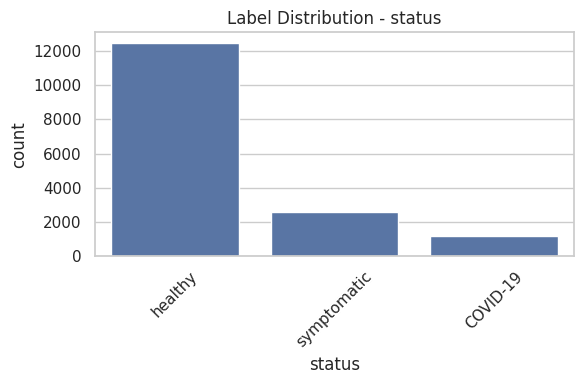

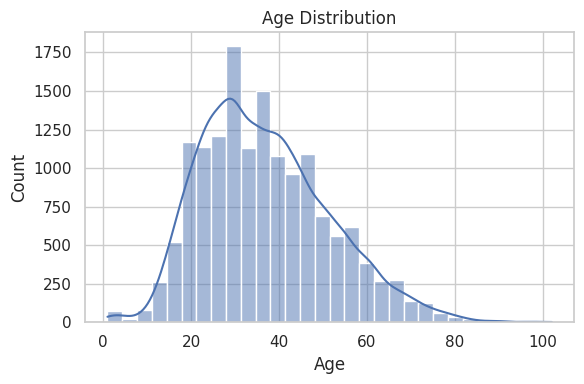

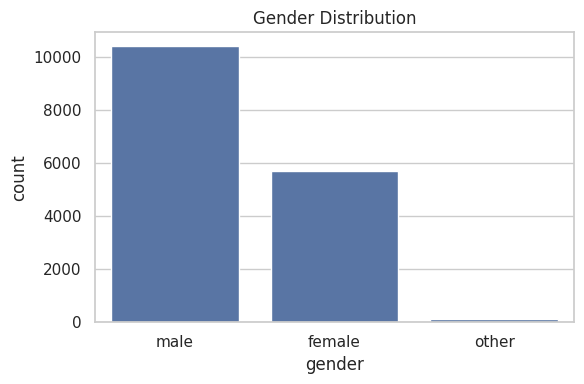

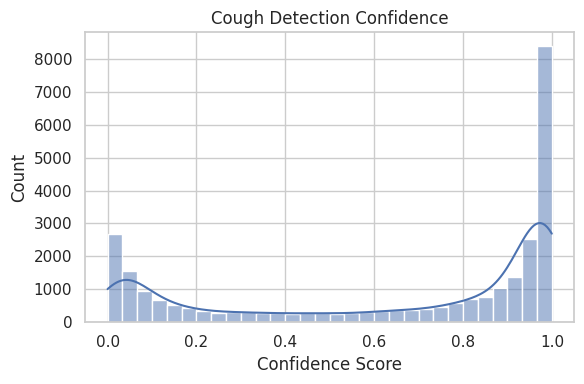

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot status distribution
plt.figure(figsize=(6,4))
sns.countplot(data=metadata, x='status', order=metadata['status'].value_counts().index)
plt.title('Label Distribution - status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot age distribution
plt.figure(figsize=(6,4))
sns.histplot(metadata['age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.tight_layout()
plt.show()

# Plot gender distribution
plt.figure(figsize=(6,4))
sns.countplot(data=metadata, x='gender')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

# Cough confidence score
plt.figure(figsize=(6,4))
sns.histplot(metadata['cough_detected'].dropna(), bins=30, kde=True)
plt.title('Cough Detection Confidence')
plt.xlabel('Confidence Score')
plt.tight_layout()
plt.show()


,Missing Count,Missing Percent
age,12332,44.76
gender,11326,41.11
status,11326,41.11
filename,0,0.00
json_file,0,0.00
cough_detected,0,0.00
respiratory_condition,0,0.00
fever_muscle_pain,0,0.00
difficulty_in_breathing,0,0.00


/tmp/ipykernel_342105/2655516366.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


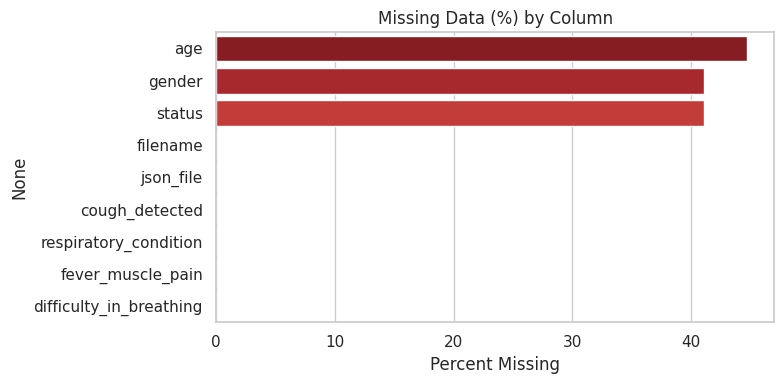

In [6]:
# Summary of missing values
missing_summary = metadata.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(metadata)) * 100

# Combine into a DataFrame for clarity
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing Percent': missing_percent.round(2)
})
display(missing_df)

# Optional: Bar plot for top missing fields
plt.figure(figsize=(8,4))
sns.barplot(
    x=missing_df['Missing Percent'],
    y=missing_df.index,
    palette='Reds_r'
)
plt.title('Missing Data (%) by Column')
plt.xlabel('Percent Missing')
plt.tight_layout()
plt.show()


In [7]:
from tqdm import tqdm

# Ensure MFCC IDs match metadata
metadata['id'] = metadata['filename'].str.replace('.wav', '', regex=False)
available_ids = set(f.replace('.npy', '') for f in mfcc_files)
metadata['has_mfcc'] = metadata['id'].isin(available_ids)

coverage = metadata['has_mfcc'].mean() * 100
print(f"Metadata rows with MFCC: {coverage:.2f}%")

# Load and inspect MFCC shape stats
frame_counts = []
n_mfccs = []

for f in tqdm(mfcc_files[:1000]):  # Sample up to 1000 files
    mfcc = np.load(os.path.join(mfccs_dir, f))
    n_mfccs.append(mfcc.shape[0])
    frame_counts.append(mfcc.shape[1])

print(f"MFCC coefficient count (mean): {np.mean(n_mfccs):.2f}")
print(f"Frame count (min–max): {np.min(frame_counts)} – {np.max(frame_counts)}")
print(f"Frame count (mean±std): {np.mean(frame_counts):.1f} ± {np.std(frame_counts):.1f}")


Metadata rows with MFCC: 32.12%


100%|██████████| 1000/1000 [00:00<00:00, 5800.08it/s]

MFCC coefficient count (mean): 40.00
Frame count (min–max): 157 – 157
Frame count (mean±std): 157.0 ± 0.0


/tmp/ipykernel_342105/673324991.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  examples = valid_df.groupby('status').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


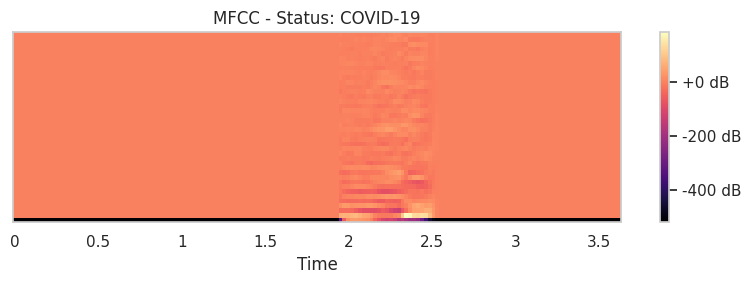

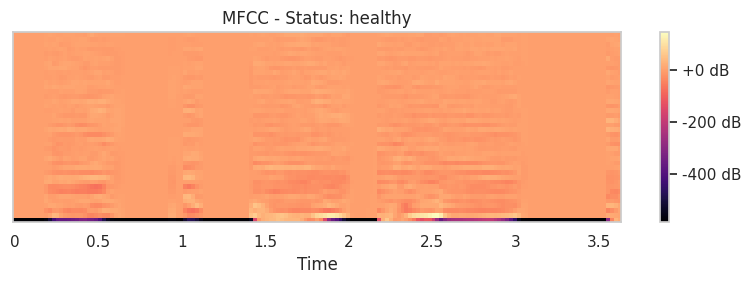

In [8]:
import librosa.display

# Filter to labeled, MFCC-matching rows
valid_df = metadata[(metadata['has_mfcc']) & (metadata['status'].notna())]

# Sample 1 from each class
examples = valid_df.groupby('status').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

for _, row in examples.iterrows():
    mfcc_path = os.path.join(mfccs_dir, f"{row['id']}.npy")
    mfcc = np.load(mfcc_path)

    plt.figure(figsize=(8, 3))
    librosa.display.specshow(mfcc, x_axis='time', cmap='magma')
    plt.title(f"MFCC - Status: {row['status']}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


In [9]:
# Filter for valid rows
clean_df = metadata[
    (metadata['has_mfcc']) &
    (metadata['status'].isin(['healthy', 'COVID-19']))
    ].copy()

# Reset index and sort by ID for consistency
clean_df = clean_df.reset_index(drop=True).sort_values('id')

# Save to processed path
processed_path = 'data/processed/metadata_clean.csv'
os.makedirs(os.path.dirname(processed_path), exist_ok=True)
clean_df.to_csv(processed_path, index=False)

print(f"✅ Clean metadata saved: {processed_path}")
print(f"Final sample count: {len(clean_df)}")


✅ Clean metadata saved: data/processed/metadata_clean.csv
Final sample count: 8850
